In [9]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
import lightgbm as lgb

## Loading data

In [10]:
data_dir = os.getcwd() + '/yelp_dataset'
data = pd.read_pickle(os.path.join(data_dir, 'features.pkl'))

In [4]:
# take 20% opened business data
# data_open = data[data['is_open']==1]
# data_close = data[data['is_open']==0]
# data_sampled = pd.concat([data_close, data_open.sample(frac=0.2, random_state=21)])

## Preprocessing

In [11]:
# prepare data sets for modeling
def prepare_data(data):
    drop_list = ['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
                 'latitude', 'longitude', 'name', 'postal_code', 'state', 'stars',]

    data = data.drop(columns=drop_list).dropna()
    data = data.replace([np.inf, -np.inf], 0)
    X = data.drop(columns='is_open')
    y = data['is_open']
    
    return X, y

In [12]:
# Oversampling
from sklearn.utils import resample

def resampling_data(data):
    # separate features and labels
    X, y = prepare_data(data)
    # split the data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    # concatenate training data back 
    t_data = pd.concat([X_train, y_train], axis=1)
    # separate open and close businesses
    data_open = t_data[t_data['is_open']==1]
    data_close = t_data[t_data['is_open']==0]
    # oversample minority
    n_samples = int(len(data_open)*0.8) 
    data_close_sampled = resample(data_close, replace=True, n_samples=n_samples, random_state=42)
    # combine majority and oversampled minority
    data_sampled = pd.concat([data_open, data_close_sampled]).sample(frac=1)
    
    return data_sampled, X_test, y_test

data_sampled, X_test, y_test = resampling_data(data)

## Tuning Parameters

In [13]:
def parameter_tuning(X_train, y_train):
    parameters = {
         'num_leaves': [10, 30, 50, 80],
         'min_data_in_leaf': [100, 300, 700, 1000],
         'learning_rate': [0.05, 0.1, 0.15, 0.2],
         }

    # apply GridSearch on random forest regression to find the best parameter 
    gs = RandomizedSearchCV(lgb.LGBMClassifier(objective='binary', n_estimators=1000), 
                           parameters, 
                           cv=5, 
                           scoring='recall', #'f1' 
                           n_jobs=-1,
                           verbose=2,
                           n_iter=20)

    gs.fit(X_train, y_train)
    print('The best parameters are:\n')
    print(gs.best_estimator_)

    means = gs.cv_results_['mean_test_score']
    stds = gs.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, gs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    return gs.best_estimator_.get_params()

X_train = data_sampled.drop(columns='is_open')
y_train = data_sampled['is_open']
best_parameter = parameter_tuning(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.5min finished


The best parameters are:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.2, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=50,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)
0.973 (+/-0.002) for {'num_leaves': 50, 'min_data_in_leaf': 100, 'learning_rate': 0.2}
0.964 (+/-0.002) for {'num_leaves': 80, 'min_data_in_leaf': 700, 'learning_rate': 0.05}
0.968 (+/-0.003) for {'num_leaves': 30, 'min_data_in_leaf': 300, 'learning_rate': 0.2}
0.968 (+/-0.002) for {'num_leaves': 50, 'min_data_in_leaf': 700, 'learning_rate': 0.15}
0.970 (+/-0.001) for {'num_leaves': 80, 'min_data_in_leaf': 700, 'learning_rate': 0.15}
0.966 (+/-0.003) for {'num_leaves': 30, 'min_data_in_leaf': 700, 'learning_ra

## lightGBM

              precision    recall  f1-score   support

           0       0.86      0.78      0.82      4475
           1       0.96      0.98      0.97     23192

   micro avg       0.94      0.94      0.94     27667
   macro avg       0.91      0.88      0.89     27667
weighted avg       0.94      0.94      0.94     27667



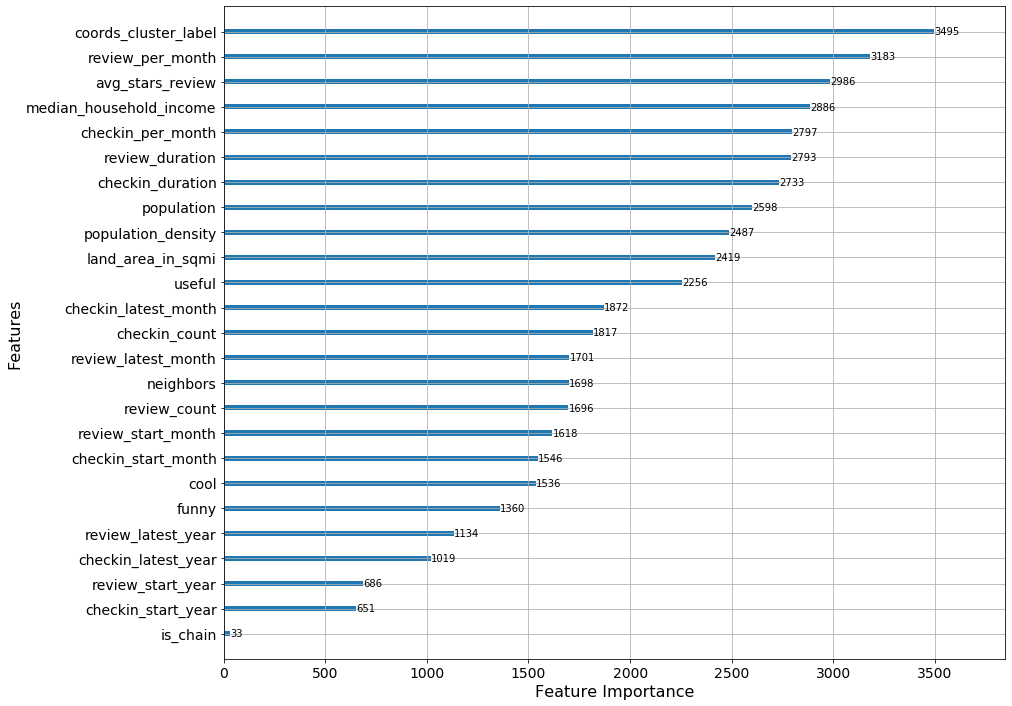

-----------------------------------------------------------
Confusion matrix
[[ 3493   982]
 [  561 22631]]
-----------------------------------------------------------
Accuracy is: 94.42%


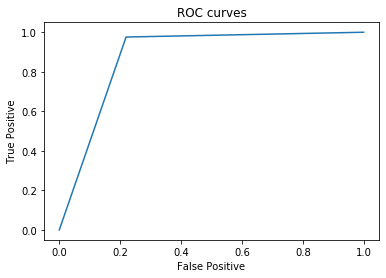

In [18]:
def lightgbm_model(data_train, X_test, y_test):
    # seprate features and labels
    X_train = data_train.drop(columns='is_open')
    y_train = data_train['is_open']
    
    # initialize lightGBM mdoel
    lgb_model = lgb.LGBMClassifier(n_estimators=1000,
                                      objective='binary',
                                      num_leaves=50,
                                      min_data_in_leaf=300,
                                      learning_rate=0.2,
                                      n_jobs=-1)
#     lgb_model.set_params(best_parameter)
    # fit the model
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_test)
    # results
    print(classification_report(y_test, y_pred))
    # plot feature importance
    fig, axes = plt.subplots()
    fig.set_size_inches(14, 12)
    lgb.plot_importance(lgb_model, ax=axes)
    axes.tick_params(axis='both', which='major', labelsize=14)
    axes.set_xlabel('Feature Importance', fontsize=16)
    axes.set_ylabel('Features', fontsize=16)
    axes.set_title('')
    plt.savefig('./report/importance.png', bbox_inches='tight', dpi=300)
    plt.show()
    # get confusion matrix
    print('-----------------------------------------------------------')
    print('Confusion matrix')
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print('-----------------------------------------------------------')
    accuracy= str(np.round((cm[0][0] + cm[1][1])/np.sum(cm), 4) *100)+'%' 
    print("Accuracy is: {}".format(accuracy))
    # plot confusion matrix
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # cax = ax.matshow(cm)
    # plt.title('Confusion matrix of the classifier')
    # fig.colorbar(cax)
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.show()
    fp, tp, _ = roc_curve(y_test, y_pred)
    plt.plot(fp, tp, label='lighGBM')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('ROC curves')
    plt.show()
    
    return fp, tp, cm, lgb_model

fp_lgb, tp_lgb, cm, lgb_model = lightgbm_model(data_sampled, X_test, y_test)

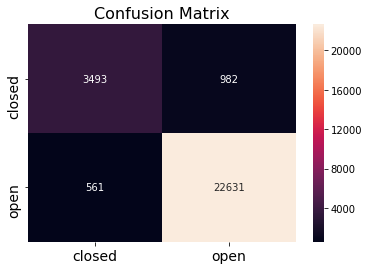

In [8]:
import seaborn as sns

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='d') #annot=True to annotate cells

# labels, title and ticks
# ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix', fontsize=16)
ax.set_xlabel('')
ax.xaxis.set_ticklabels(['closed', 'open'], fontsize=14)
ax.yaxis.set_ticklabels(['closed', 'open'], fontsize=14)
plt.savefig('./report/confusion.png', bbox_inches='tight', dpi=300)

In [ ]:
def cross_validation(X, y):
    scores = []
    cv = KFold(n_splits=10, random_state=None, shuffle=True)
    lgb_model = lgb.LGBMClassifier(n_estimators=1000,
                                       objective='binary',
                                       num_leaves=50,
                                       min_data_in_leaf=300,
                                       learning_rate=0.2,
                                       n_jobs=-1   
                                       )
    for train_index, test_index in cv.split(X):
        
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_test)
        print(classification_report(y_test, y_pred))
        print('----------------------------------------------------------')
        
    return lgb_model
    
lgb_model = cross_validation(data_sampled.drop(columns='is_open'), data_sampled['is_open'])

## Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

def logistic_regression_model(data_train, X_test, y_test):
    # seprate features and labels
    X_train = data_train.drop(columns='is_open')
    y_train = data_train['is_open']
    
    # initial logistic regression model
    lr = LogisticRegression(solver='liblinear', max_iter=1000)
    # fit the model
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    # classification results
    print('Logistic regression score for training set: %f' % lr.score(X_train, y_train))
    print('Logistic regression score for testing set: %f' % lr.score(X_test, y_test))
    print(classification_report(y_test, y_pred))
    
    fp, tp, _ = roc_curve(y_test, y_pred)
    return fp, tp
    
fp_lr, tp_lr = logistic_regression_model(data_sampled, X_test, y_test)

Logistic regression score for training set: 0.713342
Logistic regression score for testing set: 0.758846
              precision    recall  f1-score   support

           0       0.36      0.64      0.46      4475
           1       0.92      0.78      0.84     23192

   micro avg       0.76      0.76      0.76     27667
   macro avg       0.64      0.71      0.65     27667
weighted avg       0.83      0.76      0.78     27667



## Random Forests

In [9]:
from sklearn.ensemble import RandomForestClassifier

def random_forests_classifer(data_train, X_test, y_test):
    # seprate features and labels
    X_train = data_train.drop(columns='is_open')
    y_train = data_train['is_open']
    # initialize random forests model
    rf = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=21)
    # fit the model
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    # results
    print('Random Forests score for training set: %f' % rf.score(X_train, y_train))
    print('Random Forests score for testing set: %f' % rf.score(X_test, y_test))
    print('-----------------------------------------------------------')
    print(classification_report(y_test, y_pred))
#     fig, axes = plt.subplots()
#     fig.set_size_inches(16, 12)
#     feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
#     feature_importances.nlargest(10).plot(kind='barh')
#     plt.show()
        
    fp, tp, _ = roc_curve(y_test, y_pred)
    return fp, tp

fp_rf, tp_rf = random_forests_classifer(data_sampled, X_test, y_test)

Random Forests score for training set: 0.871339
Random Forests score for testing set: 0.891893
-----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.83      0.71      4475
           1       0.97      0.90      0.93     23192

   micro avg       0.89      0.89      0.89     27667
   macro avg       0.79      0.87      0.82     27667
weighted avg       0.91      0.89      0.90     27667



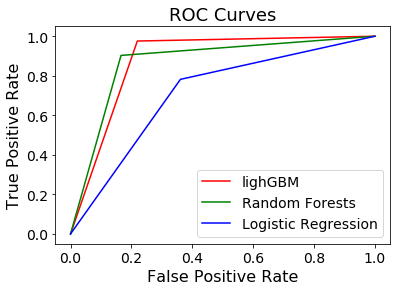

In [24]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(fp_lgb, tp_lgb, label='lighGBM', c='r')
ax.plot(fp_rf, tp_rf, label='Random Forests', c='g')
ax.plot(fp_lr, tp_lr, label='Logistic Regression', c='b')

plt.xlabel('False Positive Rate', fontsize =16)
plt.ylabel('True Positive Rate', fontsize =16)
plt.title('ROC Curves', fontsize =18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(shadow=None, fontsize=14)
plt.savefig('./report/roc.png', bbox_inches='tight', dpi=300)
plt.show()

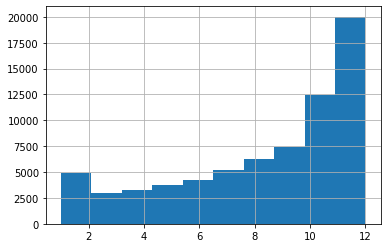

In [34]:
data_open['checkin_latest_month'].hist()

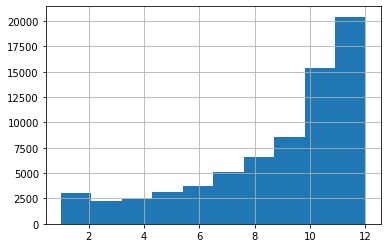

In [36]:
data_open['review_latest_month'].hist()